In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install missingno
!pip install pyLDAvis
!pip install vaderSentiment
!pip install --upgrade numpy
!pip install --upgrade seaborn
!pip install --upgrade missingno


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 30.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.3 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.2 which is incompatible.
tensorflow 2.12.0 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.2 MB/s eta 0:00:00


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# import matplotlib.colors
# plt.style.use('ggplot')

import seaborn as sns
import missingno as msno

# from jupyterthemes import jtplot
# jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

import re
import string
import json
import glob

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
nltk.download ('wordnet')

import spacy
!python -m spacy download en_core_web_md

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#vis
import pyLDAvis
import pyLDAvis.gensim

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA

AttributeError: ignored

In [ ]:
fake_news = pd.read_csv('/content/drive/MyDrive/Fake.csv')
true_news = pd.read_csv('/content/drive/MyDrive/True.csv')

In [ ]:
fake_news["fake"] = 1
true_news["fake"] = 0

In [ ]:
fake_news.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  fake  
0  December 31, 2017     1  
1  December 31, 2017     1  
2  December 30, 2017     1  
3  December 29, 2017     1  
4  December 25, 2017     1

In [ ]:
true_news.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  fake  
0  December 31, 2017      0  
1  December 29, 2017      0  
2  December 31, 2017      0  
3  December 30, 2017      0  
4  December 29, 2017      0

In [ ]:
news = pd.concat([fake_news, true_news], axis=0)

In [ ]:
#to shuffle news randomly
news = news.sample(frac=1, random_state=42)

In [ ]:
news.tail()

title  \
11284  UNREAL! CBS’S TED KOPPEL Tells Sean Hannity He...   
21251  PM May seeks to ease Japan's Brexit fears duri...   
14677  Merkel: Difficult German coalition talks can r...   
860     Trump Stole An Idea From North Korean Propaga...   
15795  BREAKING: HILLARY CLINTON’S STATE DEPARTMENT G...   

                                                    text    subject  \
11284                                                      politics   
21251  LONDON/TOKYO (Reuters) - British Prime Ministe...  worldnews   
14677  BERLIN (Reuters) - Chancellor Angela Merkel sa...  worldnews   
860    Jesus f*cking Christ our President* is a moron...       News   
15795  IF SHE S NOT TOAST NOW THEN WE RE IN BIGGER TR...   politics   

                     date  fake  
11284        Mar 27, 2017     1  
21251    August 29, 2017      0  
14677  November 16, 2017      0  
860         July 14, 2017     1  
15795        Apr 23, 2015     1

In [ ]:
print(news.shape)
news.info()

(44898, 5)
<class 'pandas.core.frame.DataFrame'>
Index: 44898 entries, 22216 to 15795
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   fake     44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


title      0
text       0
subject    0
date       0
fake       0
dtype: int64


<Axes: >

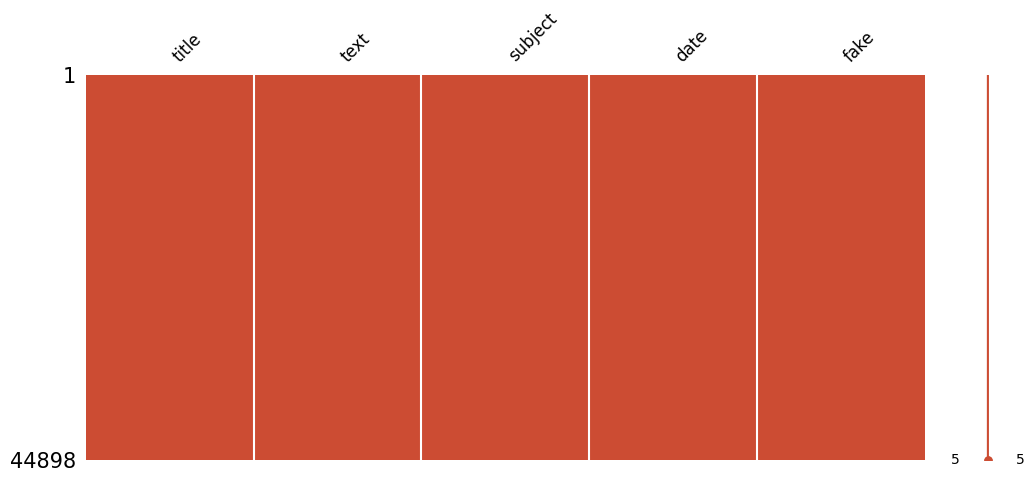

In [ ]:
print(news.isnull().sum())
msno.matrix(news,figsize=(12,5), fontsize=12, color=(0.8, 0.3, 0.2))

In [ ]:
print(news['subject'].value_counts())
print(news['date'].value_counts())

subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64
date
December 20, 2017                                                                                                                                    182
December 6, 2017                                                                                                                                     166
November 30, 2017                                                                                                                                    162
November 9, 2017                                                                                                                                     158
October 13, 2017                                                                                                                                     

In [ ]:
subject_counts = news.groupby('subject')['subject'].count()
print(subject_counts)

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: subject, dtype: int64


In [ ]:
plt.figure(figsize=(10, 6))
subject_counts.plot(kind='bar')
plt.title('Distribution of News Articles by Subject')
plt.xlabel('Subject')
plt.ylabel('Number of News Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


NameError: ignored

In [ ]:
news[news["fake"] == 1]["date"].value_counts().sort_values(ascending=False)

date
May 10, 2017                                                                                                                                         46
May 26, 2016                                                                                                                                         44
May 5, 2016                                                                                                                                          44
May 6, 2016                                                                                                                                          44
May 11, 2016                                                                                                                                         43
                                                                                                                                                     ..
December 9, 2017                                                                   

In [ ]:
# Filter the date column for dates in the format "dd-Mon-yy"
filtered_dates1 = news[news['date'].str.match(r'\d{2}-[A-Za-z]{3}-\d{2}')].reset_index()
# Filter the date column for dates in the format "mmm d, yyyy"
filtered_dates2 = news[news['date'].str.match(r'[A-Za-z]{3} \d{1,2}, \d{4}')].reset_index()
# Filter the date column for dates in the format "mmmm d, yyyy"
filtered_dates3 = news[news['date'].str.match(r'[A-Za-z]{4,} \d{1,2}, \d{4}')].reset_index()

# Strip whitespace from the 'date' column
filtered_dates1['date'] = filtered_dates1['date'].str.strip()
filtered_dates2['date'] = filtered_dates2['date'].str.strip()
filtered_dates3['date'] = filtered_dates3['date'].str.strip()

In [ ]:
filtered_dates3['date'].isnull().sum()

0

In [ ]:
# Convert the dates using pd.to_datetime with errors='coerce' and format
filtered_dates1['date'] = pd.to_datetime(filtered_dates1['date'], format='%d-%b-%y', errors='coerce', infer_datetime_format=True)
filtered_dates2['date'] = pd.to_datetime(filtered_dates2['date'], format='%b %d, %Y', errors='coerce', infer_datetime_format=True)
filtered_dates3['date'] = pd.to_datetime(filtered_dates3['date'], format='%B %d, %Y', errors='coerce', infer_datetime_format=True)


<ipython-input-16-eab97ba8aa00>:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  filtered_dates1['date'] = pd.to_datetime(filtered_dates1['date'], format='%d-%b-%y', errors='coerce', infer_datetime_format=True)
<ipython-input-16-eab97ba8aa00>:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  filtered_dates2['date'] = pd.to_datetime(filtered_dates2['date'], format='%b %d, %Y', errors='coerce', infer_datetime_format=True)
<ipython-input-16-eab97ba8aa00>:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version.

In [ ]:
# Concatenate the filtered DataFrames vertically
news = pd.concat([filtered_dates1, filtered_dates2, filtered_dates3], ignore_index=True)

In [ ]:
print(news.shape)
news.info()

(44888, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44888 entries, 0 to 44887
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   index    44888 non-null  int64         
 1   title    44888 non-null  object        
 2   text     44888 non-null  object        
 3   subject  44888 non-null  object        
 4   date     44888 non-null  datetime64[ns]
 5   fake     44888 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 2.1+ MB


In [ ]:
news['fake'].value_counts().sort_values(ascending=False)

fake
1    23471
0    21417
Name: count, dtype: int64

In [ ]:
# Extract the year from the datetime objects and get unique years
unique_years = news['date'].dt.year.unique()
print(unique_years)

[2018 2017 2016 2015]


In [ ]:
# Filtering out all dates after 08/11/16 which is the election data
cutoff_date = pd.to_datetime('2016-08-11')
news = news[news['date'] <= cutoff_date]

In [ ]:
print(news.shape)
news.info()

(12546, 6)
<class 'pandas.core.frame.DataFrame'>
Index: 12546 entries, 37 to 44877
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   index    12546 non-null  int64         
 1   title    12546 non-null  object        
 2   text     12546 non-null  object        
 3   subject  12546 non-null  object        
 4   date     12546 non-null  datetime64[ns]
 5   fake     12546 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 686.1+ KB


In [ ]:
print(news['subject'].value_counts())

subject
News               3964
politicsNews       2797
politics           2615
left-news          1782
Government News    1001
US_News             196
Middle-east         191
Name: count, dtype: int64


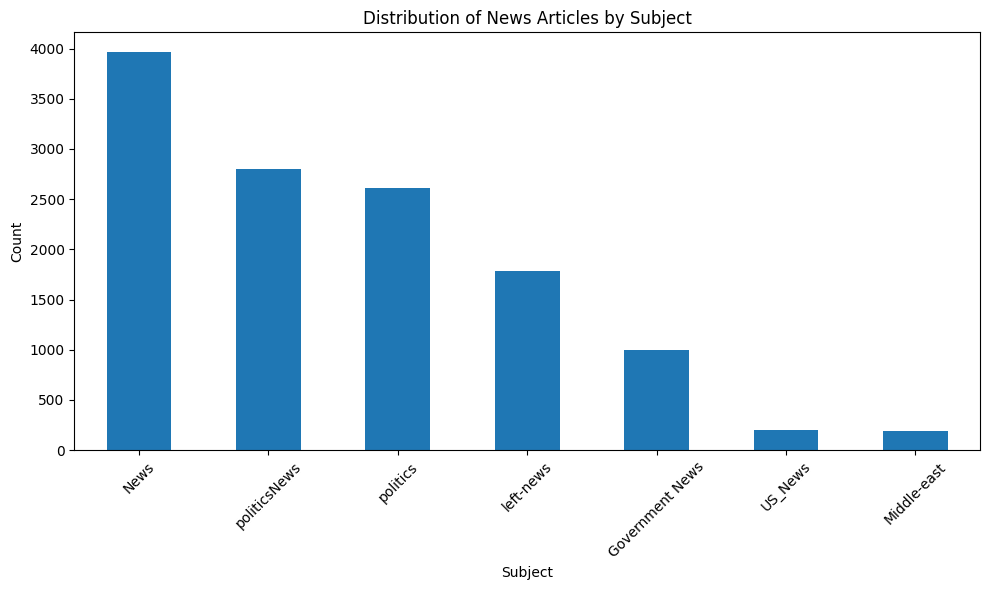

In [ ]:
# Count of each subject category
subject_counts = news['subject'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
subject_counts.plot(kind='bar')
plt.title('Distribution of News Articles by Subject')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Add new features for word count and total number of character
news['word_count'] = news['text'].str.count(r'\w+')
news['char_count'] = news['text'].str.len()
news.describe()

index                           date          fake  \
count  12546.000000                          12546  12546.000000   
mean   12521.652001  2016-02-28 15:32:13.428981504      0.777060   
min     5086.000000            2015-03-31 00:00:00      0.000000   
25%     8222.250000            2016-01-17 00:00:00      1.000000   
50%    10783.500000            2016-03-19 00:00:00      1.000000   
75%    16490.750000            2016-05-26 00:00:00      1.000000   
max    23480.000000            2016-08-11 00:00:00      1.000000   
std     5272.508519                            NaN      0.416235   

         word_count    char_count  
count  12546.000000  12546.000000  
mean     434.092858   2540.239439  
min        0.000000      1.000000  
25%      257.000000   1497.000000  
50%      391.000000   2273.500000  
75%      537.000000   3118.500000  
max     5506.000000  32932.000000  
std      344.744490   2033.621521

In [ ]:
# Count the number of articles with less than 20 words
print(len(news[news['word_count'] < 20]))

330


In [ ]:
# Filter rows with less than 20 words and drop them
news = news[news['word_count'] >= 20]

In [ ]:
# Define the regular expression pattern for text cleaning
text_cleaning_re = "@\S+|https?:\S+|http?:\S+|[^A-Za-z0-9]+"
TAG_RE = re.compile(r'<[^>]+>')


# Function to clean text
def clean_text(text, stem=False):
    # Remove HTML tags
    text = TAG_RE.sub('', text)

    # Remove special characters, mentions, and URLs
    text = re.sub(text_cleaning_re, ' ', text)

    # Convert text to lowercase
    text = text.lower()

    # Remove integers
    text = ''.join([i for i in text if not i.isdigit()])

    # Remove punctuation marks
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Remove single characters
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)

    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)

    return text

In [ ]:
# Apply text cleaning to 'news["text"]' column
news["cleantext"] = news["text"].apply(lambda x: clean_text(x))

print(news["cleantext"])

37       he been europe version of the outspoken ted cr...
38        this version of the story corrects the figure...
40       before you blame trump for not being compassio...
41       does judge have the right to determine what mo...
44       that gonna leave mark former vice president di...
                               ...                        
44843    the democrats in the house of representatives ...
44844    it quite hard to laugh at what donald trump pl...
44857    a state republican in georgia made an astonish...
44860    rowan county clerk kim davis already had her f...
44877    rumors that the dnc hack was tied to russia ha...
Name: cleantext, Length: 12216, dtype: object


# **Clustering**

In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Word embedding for **Kmeans**
To find the optimum number of clusters in your data after obtaining word embedding using Word2Vec, you can use various clustering evaluation metrics or techniques. One popular approach is the "Elbow Method", which helps you determine the optimal number of clusters based on the within-cluster sum of squares(inertia) of the data points


In [ ]:
# Tokenize the text data
news['tokenized_text'] = news['cleantext'].apply(lambda x: word_tokenize(x.lower()))

In [ ]:
# Train Word2Vec model
model = Word2Vec(sentences=news['tokenized_text'], vector_size=100, window=5, min_count=1, workers=4)

# Get the word embeddings for each sentence
def get_sentence_embeddings(sentence):
    embeddings = []
    for word in word_tokenize(sentence):
        if word in model.wv:
            embeddings.append(model.wv[word])
    return embeddings


In [ ]:
# Apply the function to 'news.cleantext' column
news['word2vec_embeddings'] = news['cleantext'].apply(lambda x: get_sentence_embeddings(x))

In [ ]:
print(news['word2vec_embeddings'])

37       [[0.06609872, 1.8489826, -0.584991, -3.1757615...
38       [[2.3108344, -0.7403049, -0.69338155, 0.105050...
40       [[-1.1368506, -1.7062305, -2.6927648, -0.96180...
41       [[1.4540021, -2.4657588, 2.2333336, -0.9872317...
44       [[0.96685165, 0.71443695, 1.3671361, -0.774063...
                               ...                        
44843    [[-0.06829446, 0.10742707, -0.24229753, -0.835...
44844    [[-0.06705555, -0.3545035, -0.18790463, -0.732...
44857    [[1.9365177, -3.9065845, -0.07039282, 0.022834...
44860    [[-0.18868782, 0.039764818, 0.138718, 0.004024...
44877    [[-0.14083272, -0.19817604, 0.4723573, -0.5808...
Name: word2vec_embeddings, Length: 12216, dtype: object


# **Finding optimal number of clusters**

In [ ]:
# Calculate the average word embeddings for each sentence
def average_embedding(embeddings):
    if len(embeddings) == 0:
        return np.zeros(100)  # If there are no embeddings, return a vector of zeros
    else:
        return np.mean(embeddings, axis=0)

# Calculate average embeddings for each sentence and create a fixed-size representation
news['word2vec_average_embeddings'] = news['word2vec_embeddings'].apply(average_embedding)

In [ ]:
news['word2vec_average_embeddings']

37       [0.27687797, -0.19533744, -0.1664743, -0.20409...
38       [0.11592135, 0.014751304, 0.030764058, -0.5124...
40       [0.069834836, -0.17727241, -0.057894282, -0.54...
41       [0.019753693, -0.23091665, 0.24115524, -0.4691...
44       [0.00053330726, 0.13160597, 0.015173107, -0.78...
                               ...                        
44843    [0.21293084, -0.16131528, 0.067336224, -0.5632...
44844    [-0.012050722, -0.33944222, -0.011220309, -0.7...
44857    [0.17128785, -0.05327546, 0.05450781, -0.50893...
44860    [-0.0049691973, -0.29820272, 0.09798242, -0.45...
44877    [0.029588126, 0.077848434, 0.109462075, -0.387...
Name: word2vec_average_embeddings, Length: 12216, dtype: object

In [ ]:
# Prepare data for clustering
X_avg = np.vstack(news['word2vec_average_embeddings'])

In [ ]:
X_avg.shape

(12216, 100)

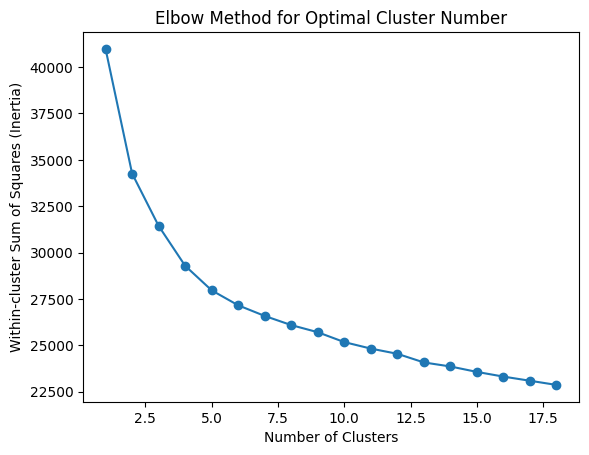

In [ ]:
# # Prepare data for clustering
# X = [emb for embeddings in news['word2vec_embeddings'] for emb in embeddings]

# Find the optimal number of clusters using the Elbow Method
inertia_values = []
max_clusters = 18
for num_clusters in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, init="k-means++", max_iter=100, n_init=1)
    kmeans.fit(X_avg)
    inertia_values.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.plot(range(1, max_clusters + 1), inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-cluster Sum of Squares (Inertia)')
plt.title('Elbow Method for Optimal Cluster Number')
plt.show()

In [ ]:
# Labeling the rows of the dataframe with cluster labels
# Perform clustering with 5 clusters
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42, init="k-means++", max_iter=100, n_init=1)
cluster_labels = kmeans.fit_predict(X_avg)

# Add cluster labels to the news dataframe
news['cluster_label'] = cluster_labels
news['cluster_label'].value_counts()

cluster_label
2    2895
1    2633
0    2498
4    2279
3    1911
Name: count, dtype: int64

In [ ]:
# Printing the Hotwords of every cluster
print("Cluster Hotwords")
# Get the cluster centers (mean word embeddings) from the KMeans model
cluster_centers = kmeans.cluster_centers_

for i in range(num_clusters):
    print(f"Cluster {i}")
    # Get the indices of the top 20 words with highest similarity to the cluster center
    top_word_indices = cluster_centers[i].argsort()[::-1][:20]
    # Get the corresponding words from the Word2Vec model
    hotwords = [model.wv.index_to_key[index] for index in top_word_indices]
    for word in hotwords:
        print(word)
    print("-------------------------")

Cluster Hotwords
Cluster 0
he
all
president
against
donald
its
clinton
also
even
because
with
been
house
how
said
police
new
when
to
an
-------------------------
Cluster 1
all
he
also
said
its
with
donald
clinton
against
how
when
president
s
will
even
on
because
one
house
other
-------------------------
Cluster 2
also
all
he
its
on
said
when
one
with
other
donald
clinton
will
even
could
because
more
had
s
against
-------------------------
Cluster 3
all
also
he
even
on
its
one
with
donald
clinton
when
can
could
been
because
against
president
other
to
house
-------------------------
Cluster 4
all
its
he
because
also
clinton
donald
when
will
how
been
even
on
america
president
said
against
are
house
one
-------------------------


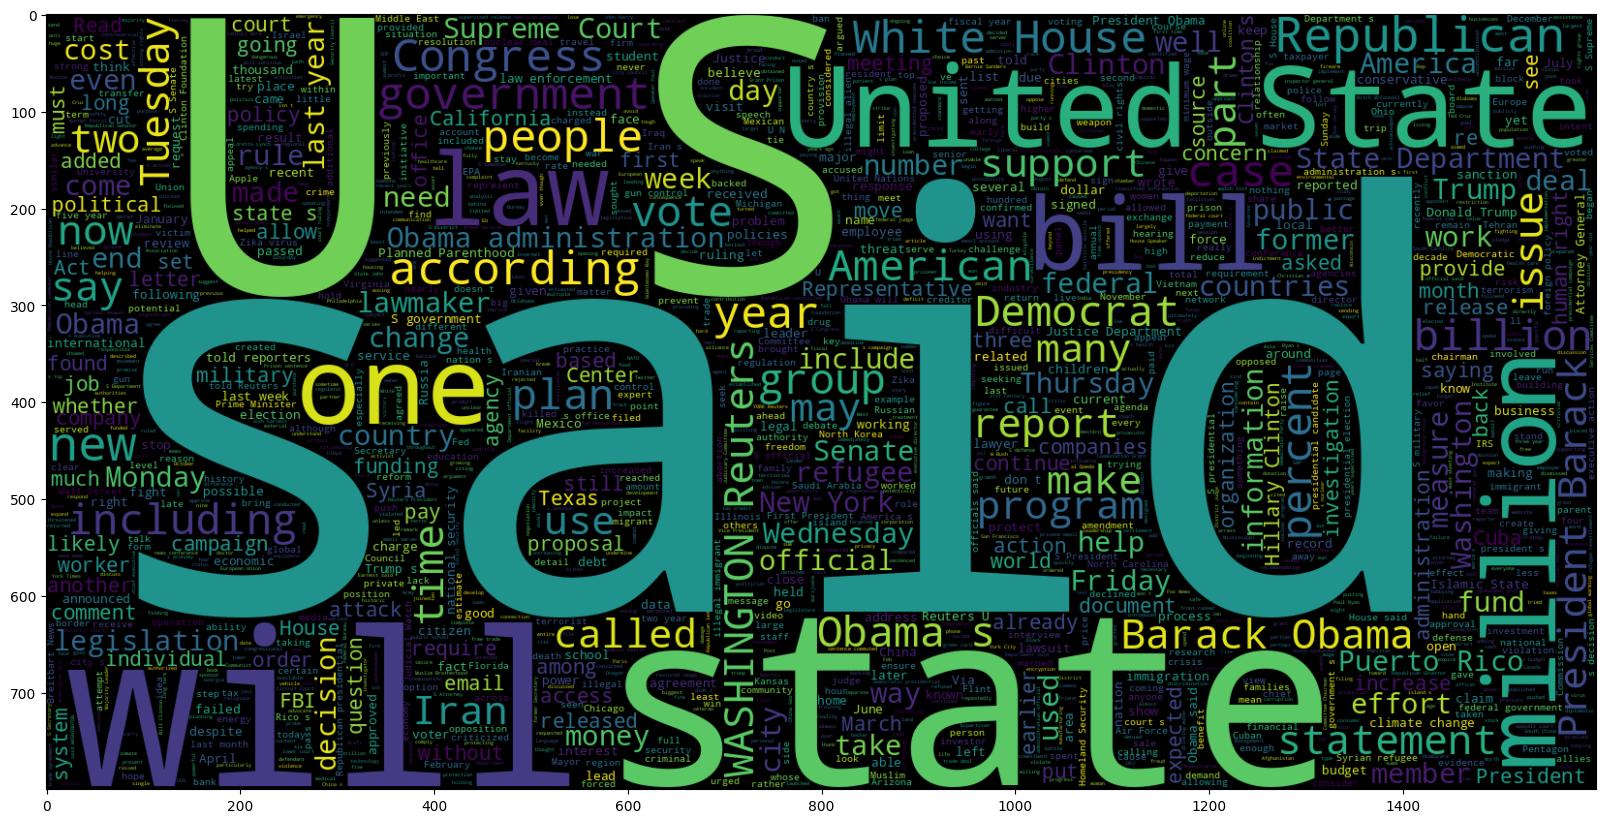

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(news[news.cluster_label == 0 ].text))
plt.imshow(wc , interpolation = 'bilinear')

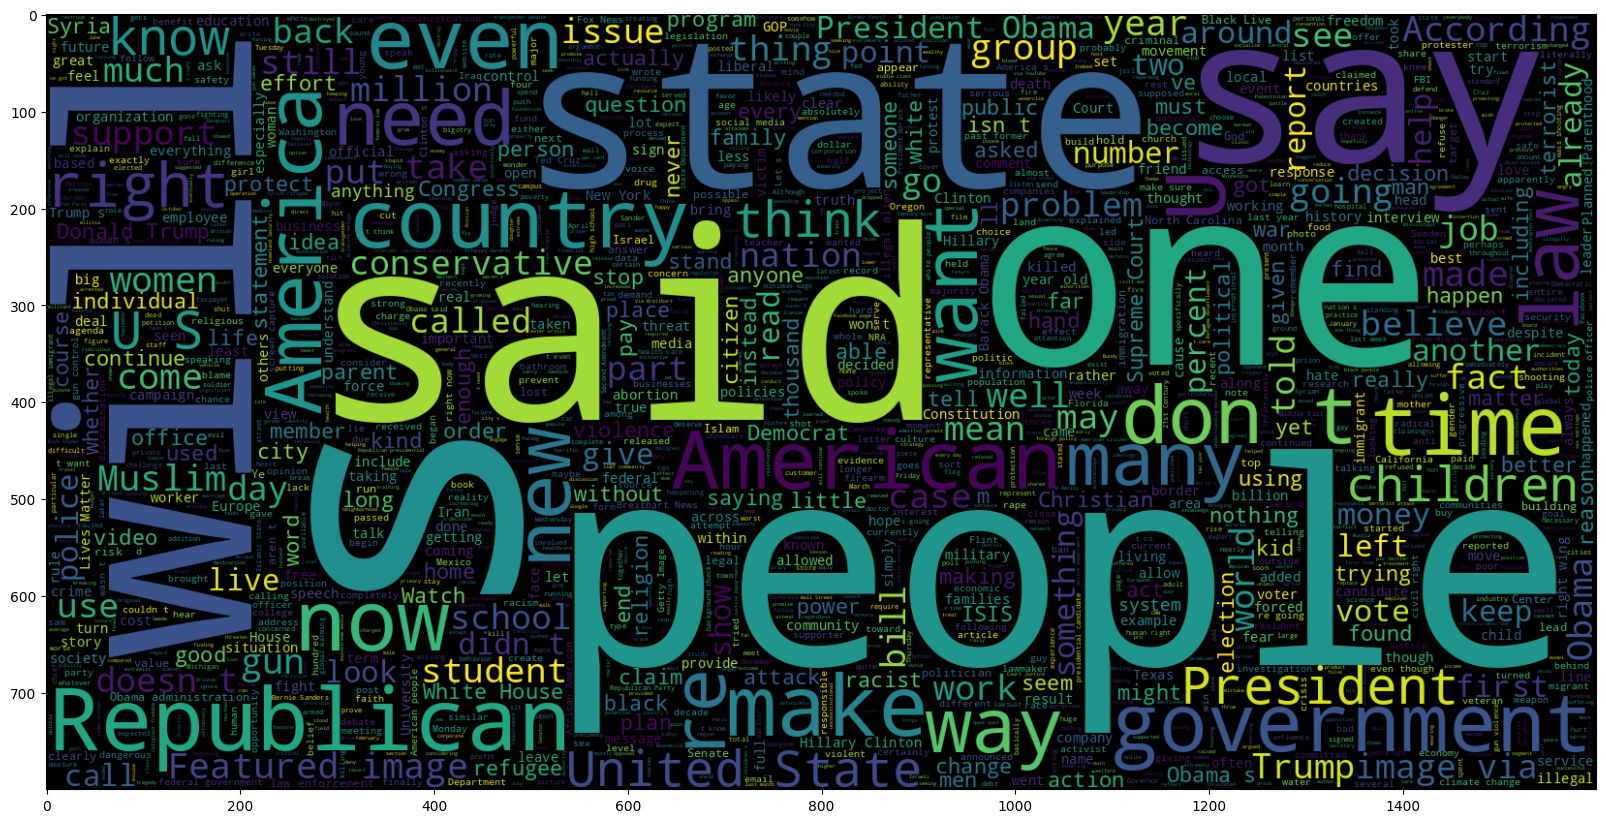

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(news[news.cluster_label == 1 ].text))
plt.imshow(wc , interpolation = 'bilinear')

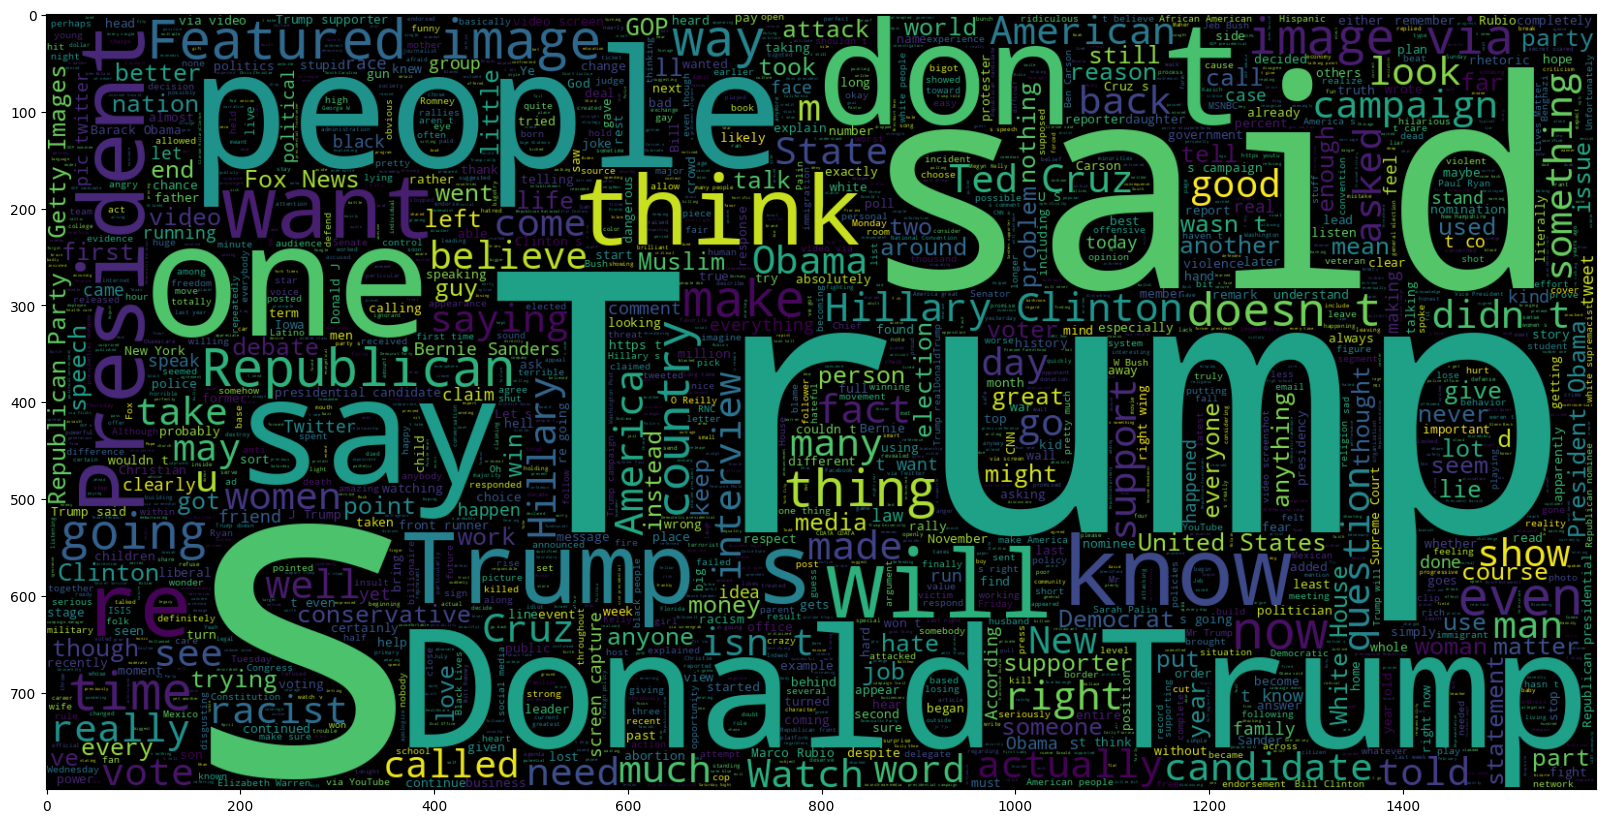

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(news[news.cluster_label == 2 ].text))
plt.imshow(wc , interpolation = 'bilinear')

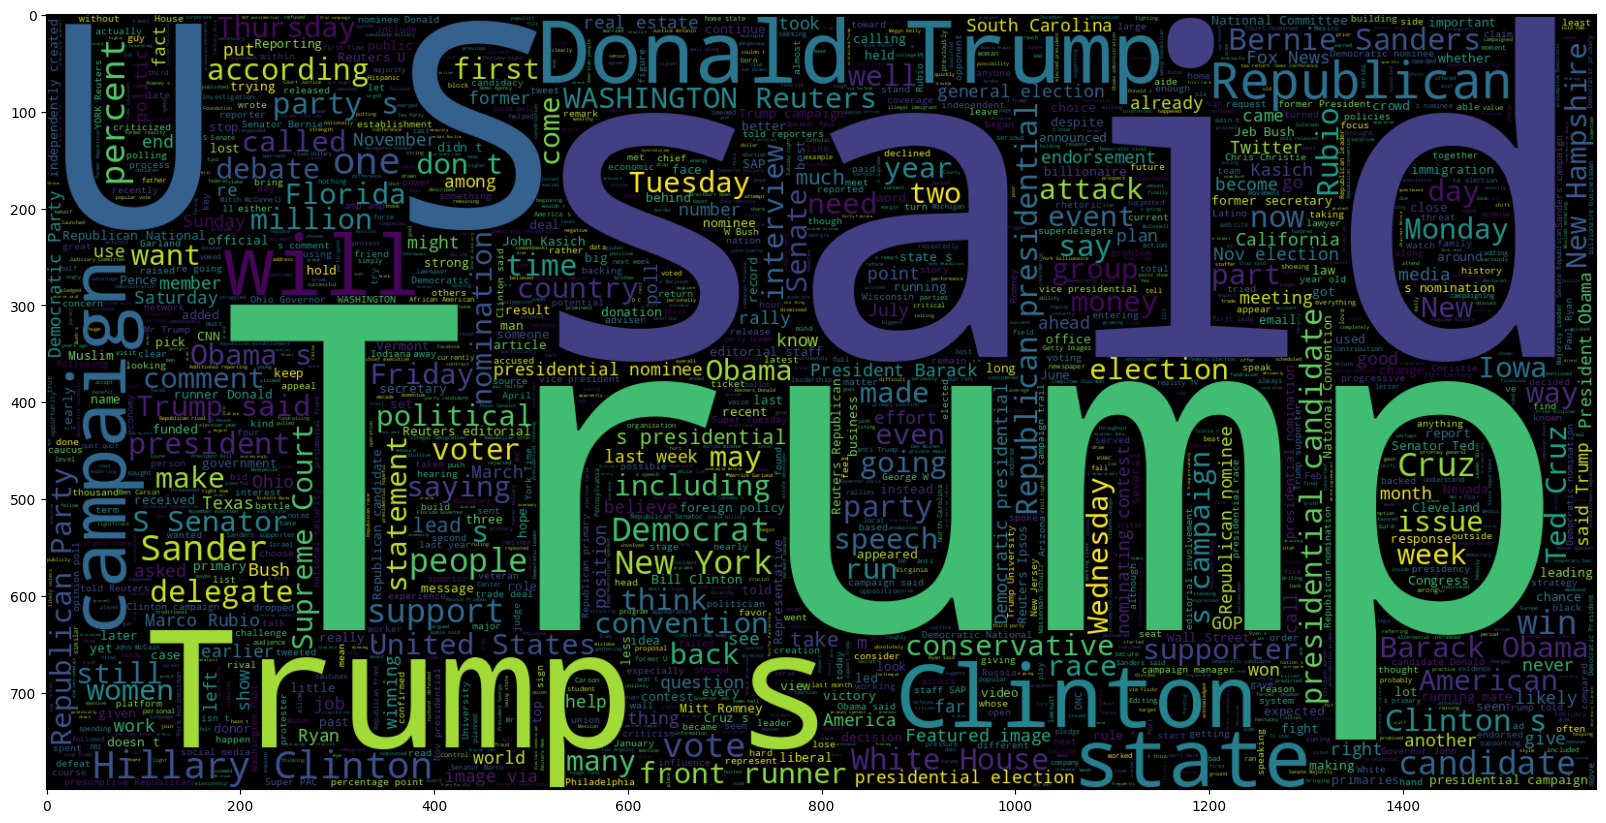

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(news[news.cluster_label == 3 ].text))
plt.imshow(wc , interpolation = 'bilinear')

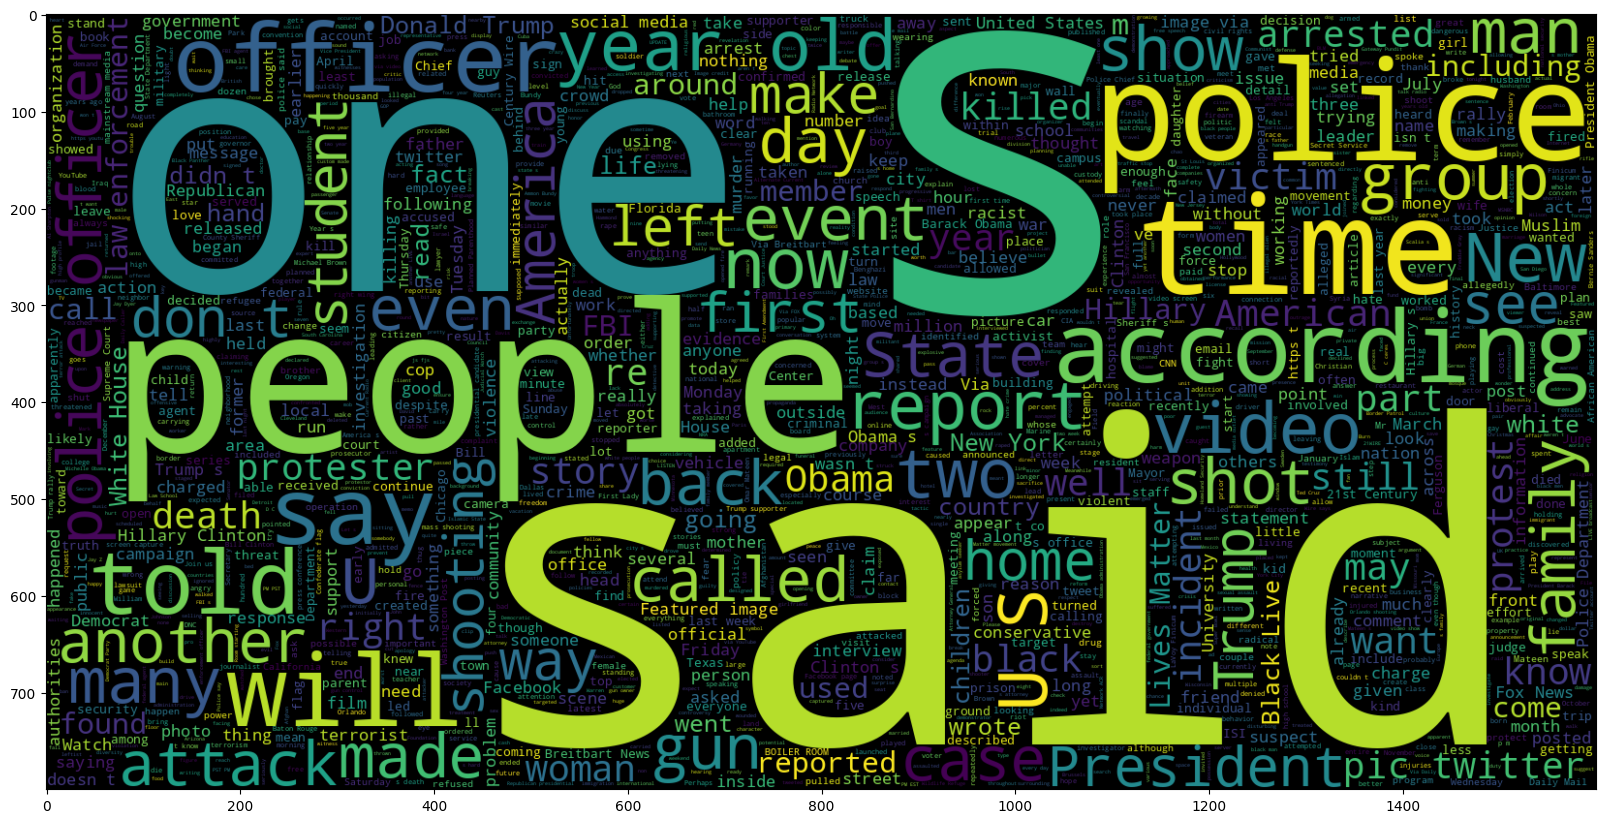

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(news[news.cluster_label == 4 ].text))
plt.imshow(wc , interpolation = 'bilinear')

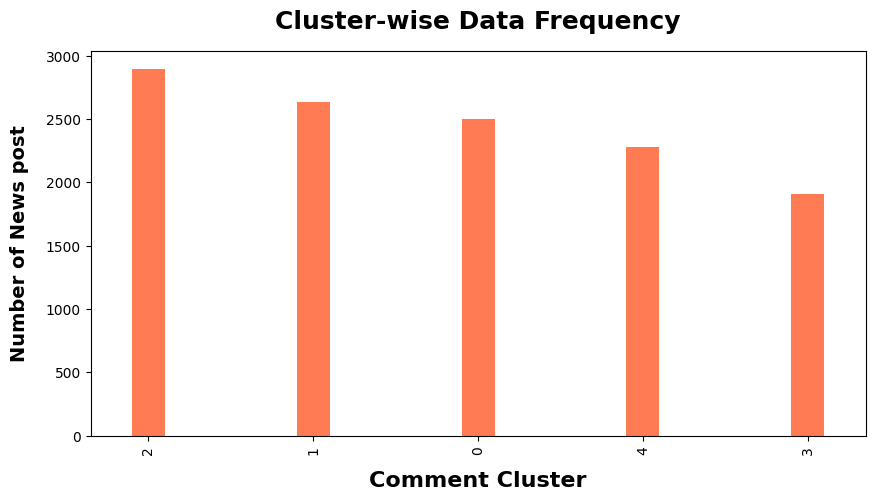

In [ ]:
# Plot cluster-wise data frequency
cluster_counts = news['cluster_label'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
cluster_counts.plot(kind='bar', width=0.2, color="#FF7B54")

plt.xlabel("Comment Cluster", fontsize=16, fontweight="semibold", labelpad=12)
plt.ylabel("Number of News post", fontsize=14, fontweight="semibold", labelpad=12)
plt.title("Cluster-wise Data Frequency", fontsize=18, pad=16, fontweight="bold")

plt.show()

<Figure size 1000x500 with 0 Axes>

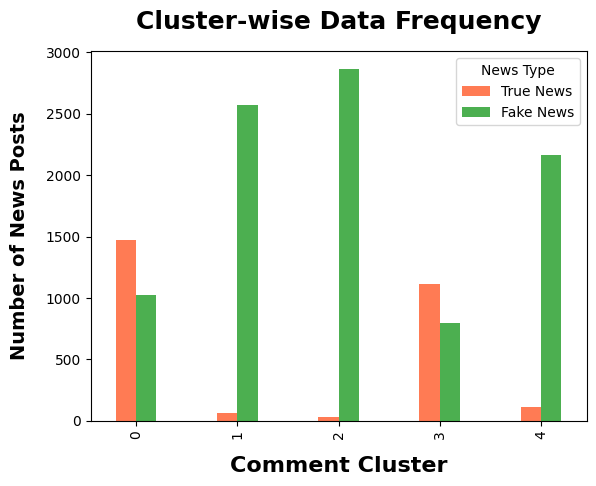

In [ ]:
# Plot cluster-wise data frequency for true and fake news
cluster_counts = news.groupby(['cluster_label', 'fake']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 5))
cluster_counts.plot(kind='bar', width=0.4, color=["#FF7B54", "#4CAF50"])

plt.xlabel("Comment Cluster", fontsize=16, fontweight="semibold", labelpad=12)
plt.ylabel("Number of News Posts", fontsize=14, fontweight="semibold", labelpad=12)
plt.title("Cluster-wise Data Frequency", fontsize=18, pad=16, fontweight="bold")
plt.legend(title="News Type", labels=["True News", "Fake News"])

plt.show()

In [ ]:
news['fake'].value_counts().sort_values(ascending=False)

fake
1    9420
0    2796
Name: count, dtype: int64

In [ ]:
# Creating list of Frequent words from the 'cleantext' column
freq = pd.Series(' '.join(news['cleantext']).split()).value_counts()[:6]

# Removing frequent words from the 'cleantext' column
news['cleantext'] = news['cleantext'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

# Creating a series with all words from the 'cleantext' column
all_word_series = pd.Series(' '.join(news['cleantext']).split()).value_counts()

# Creating a list of words that have appeared less than 4 times in the entire corpus
rare = all_word_series[all_word_series < 3].index.tolist()

# Removing rare words from the 'cleantext' column
news['cleantext'] = news['cleantext'].apply(lambda x: " ".join(x for x in x.split() if x not in rare))

In [ ]:
# Create a new DataFrame "news2" with the specified columns
cp = news.copy()

In [ ]:
# Create a new DataFrame "news2" with the specified columns
news = news[['title', 'text', 'subject', 'date', 'fake', 'word_count', 'char_count', 'cleantext', 'tokenized_text', 'cluster_label']].copy()
news.to_csv('/content/drive/MyDrive/Colab Notebooks/lda_data.csv', index=False)

In [ ]:
# Lemmatization using spaCy
import spacy

# Creating nlp object
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

# User-defined function to perform lemmatization of the 'cleantext' column
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    output = []
    for sent in texts:
        doc = nlp(sent)
        output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return output

# Lemmatization of the 'cleantext' column
text_list = news['cleantext'].tolist()
tokenized_reviews = lemmatization(text_list)

In [ ]:
print(text_list[1])
print(tokenized_reviews[1])

this version story corrects figure for current minimum wage from paragraph two washington reuters donald trump presumptive republican presidential nominee said on wednesday he was open doing something with country minimum wage but added any increase would have be weighed against potential loss competitiveness m open doing something with it trump said an interview with cnn adding he did not like current an hour level mean you have something you can live on but what really do like is bring our jobs back so they re making much more than dollars an hour he added
['version', 'story', 'correct', 'figure', 'current', 'minimum', 'wage', 'paragraph', 'presumptive', 'republican', 'presidential', 'nominee', 'say', 'open', 'do', 'country', 'minimum', 'wage', 'add', 'increase', 'weigh', 'potential', 'loss', 'competitiveness', 'm', 'open', 'do', 'trump', 'say', 'interview', 'add', 'like', 'current', 'hour', 'level', 'live', 'really', 'bring', 'job', 'back', 're', 'make', 'much', 'more', 'dollar', 'h

In [ ]:
# Creating bigrams and trigrams for LDA
bigram_phrases = gensim.models.Phrases(tokenized_reviews, min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[tokenized_reviews], threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return [bigram[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram[bigram[doc]] for doc in texts]

data_bigrams = make_bigrams(tokenized_reviews)
data_bigrams_trigrams = make_trigrams(data_bigrams)

# Removing frequent words from bigrams and trigrams and generating TF-IDF model
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)
texts = data_bigrams_trigrams
corpus = [id2word.doc2bow(text) for text in texts]
tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = []
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words + words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids]

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

/usr/local/lib/python3.10/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in scalar divide
  m_lr_i = np.log(numerator / denominator)
/usr/local/lib/python3.10/dist-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in scalar divide
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


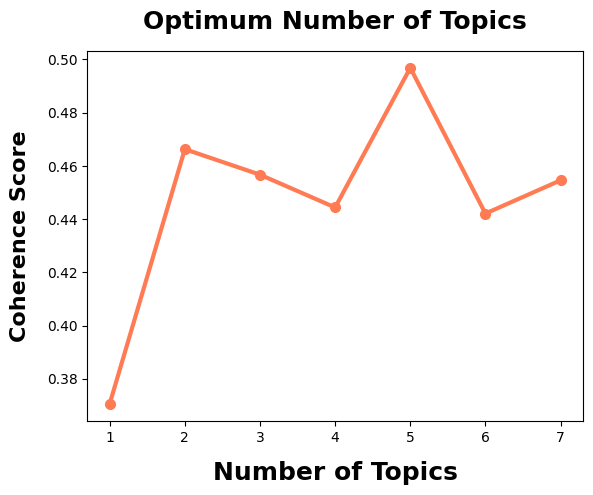

In [ ]:
# Finding Optimum topic number
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state=1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Generating LDA model and calculating Coherence score for them.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=tokenized_reviews, start=1, limit=10, step=1)

# Plotting the Coherence score for different numbers of topics to find out the optimum number of topics
import matplotlib.pyplot as plt

limit = 10
start = 1
step = 1
x = range(start, limit, step)
plt.plot(x, coherence_values, color="#FF7B54", marker='.', markersize=14, linewidth=3)
plt.title("Optimum Number of Topics", fontsize=18, fontweight="bold", pad=16)
plt.xlabel("Number of Topics", fontsize=18, fontweight="semibold", labelpad=12)
plt.ylabel("Coherence Score", fontsize=16, fontweight="semibold", labelpad=12)
plt.show()

In [ ]:
# Printing the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.3706
Num Topics = 2  has Coherence Value of 0.4663
Num Topics = 3  has Coherence Value of 0.4567
Num Topics = 4  has Coherence Value of 0.4444
Num Topics = 5  has Coherence Value of 0.4968
Num Topics = 6  has Coherence Value of 0.4421
Num Topics = 7  has Coherence Value of 0.4546
Num Topics = 8  has Coherence Value of nan
Num Topics = 9  has Coherence Value of nan


In [ ]:
!pip install --upgrade pyLDAvis

In [ ]:
# Optimum Model for LDA
# Select the model and print the topics
optimal_model = model_list[8]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.015*"people" + 0.012*"right" + 0.006*"use" + 0.005*"hate" + 0.005*"state" + 0.005*"man" + 0.004*"woman" + 0.004*"make" + 0.004*"transgender" + 0.004*"bathroom"'),
 (1,
  '0.018*"say" + 0.008*"people" + 0.007*"go" + 0.007*"know" + 0.007*"trump" + 0.006*"just" + 0.005*"get" + 0.005*"so" + 0.005*"make" + 0.004*"woman"'),
 (2,
  '0.019*"police" + 0.013*"officer" + 0.010*"group" + 0.009*"report" + 0.008*"event" + 0.008*"protester" + 0.007*"black" + 0.007*"protest" + 0.006*"city" + 0.005*"federal"'),
 (3,
  '0.020*"gun" + 0.011*"state" + 0.011*"law" + 0.009*"bill" + 0.007*"year" + 0.006*"vote" + 0.006*"pass" + 0.006*"republican" + 0.005*"legislation" + 0.005*"court"'),
 (4,
  '0.010*"student" + 0.010*"state" + 0.008*"government" + 0.008*"email" + 0.008*"federal" + 0.008*"school" + 0.008*"public" + 0.006*"finicum" + 0.005*"report" + 0.005*"investigation"'),
 (5,
  '0.011*"woman" + 0.008*"right" + 0.008*"people" + 0.008*"child" + 0.007*"shoot" + 0.006*"old" + 0.006*"police" + 0.006*"

# **Sentiment Analysis**

In [ ]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate sentiment score for each title and text
def get_sentiment_score(row):
    title_score = analyzer.polarity_scores(row['title'])['compound']
    text_score = analyzer.polarity_scores(row['text'])['compound']
    return (title_score, text_score)

# Apply the function and store the scores in new columns
news['title_sentiment_score'], news['text_sentiment_score'] = zip(*news.apply(get_sentiment_score, axis=1))

In [ ]:
from textblob import TextBlob

# Function to calculate sentiment polarity for each title and text using TextBlob
def get_textblob_sentiment(row):
    title_polarity = TextBlob(row['title']).sentiment.polarity
    text_polarity = TextBlob(row['text']).sentiment.polarity
    return (title_polarity, text_polarity)

# Apply the function and store the polarity in new columns
news['title_textblob_polarity'], news['text_textblob_polarity'] = zip(*news.apply(get_textblob_sentiment, axis=1))

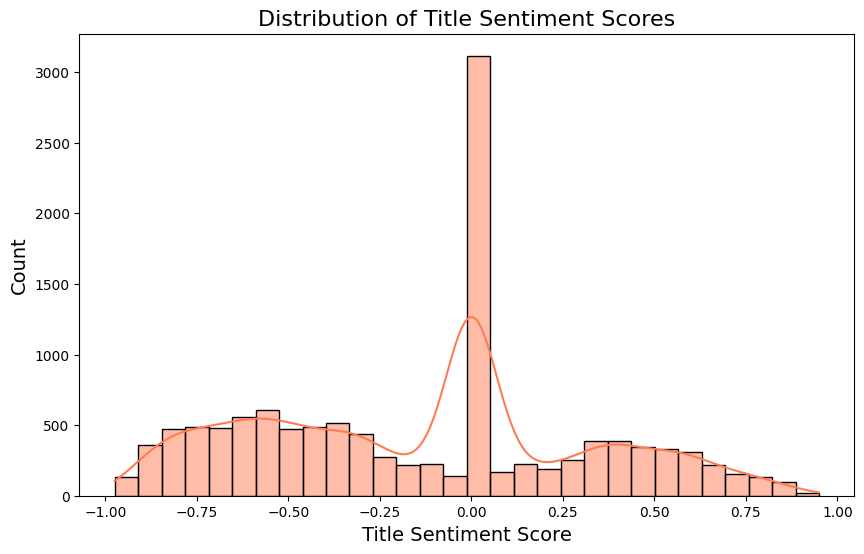

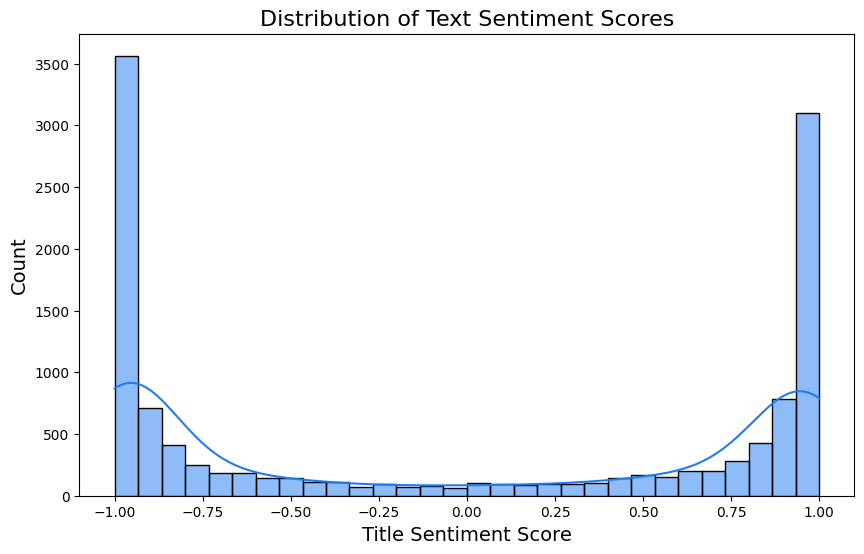

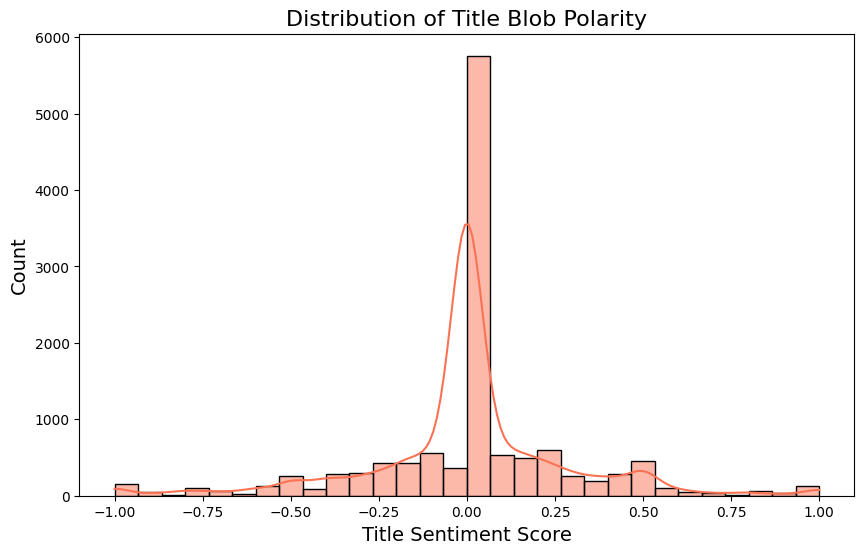

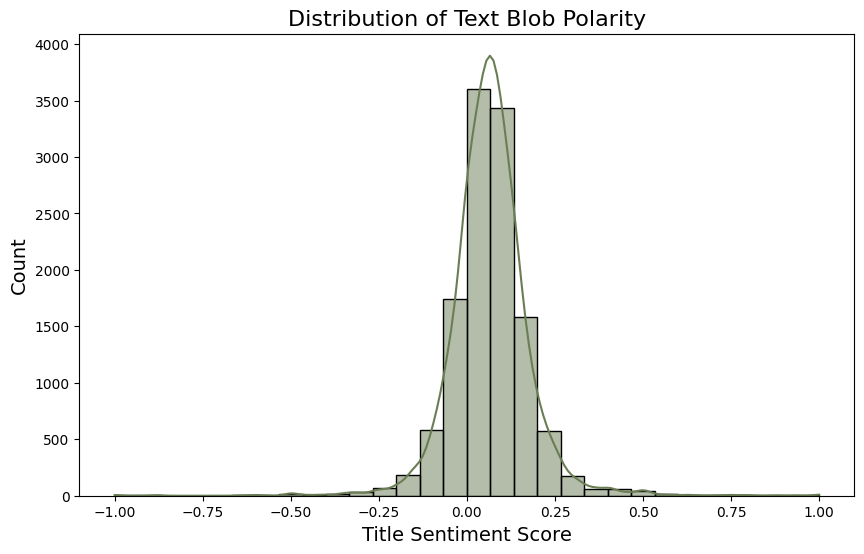

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting distribution of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(news['title_sentiment_score'], bins=30, color='#FF7B54', kde=True)
plt.xlabel('Title Sentiment Score', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Title Sentiment Scores', fontsize=16)
plt.show()


plt.figure(figsize=(10, 6))
sns.histplot(news['text_sentiment_score'], bins=30, color='#1F7BF4', kde=True)
plt.xlabel('Title Sentiment Score', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Text Sentiment Scores', fontsize=16)
plt.show()

# Plotting distribution of blob polarities
plt.figure(figsize=(10, 6))
sns.histplot(news['title_textblob_polarity'], bins=30, color='#FA7254', kde=True)
plt.xlabel('Title Sentiment Score', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Title Blob Polarity', fontsize=16)
plt.show()


plt.figure(figsize=(10, 6))
sns.histplot(news['text_textblob_polarity'], bins=30, color='#6A7D54', kde=True)
plt.xlabel('Title Sentiment Score', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Text Blob Polarity', fontsize=16)
plt.show()


In [ ]:
nnews = news.copy()

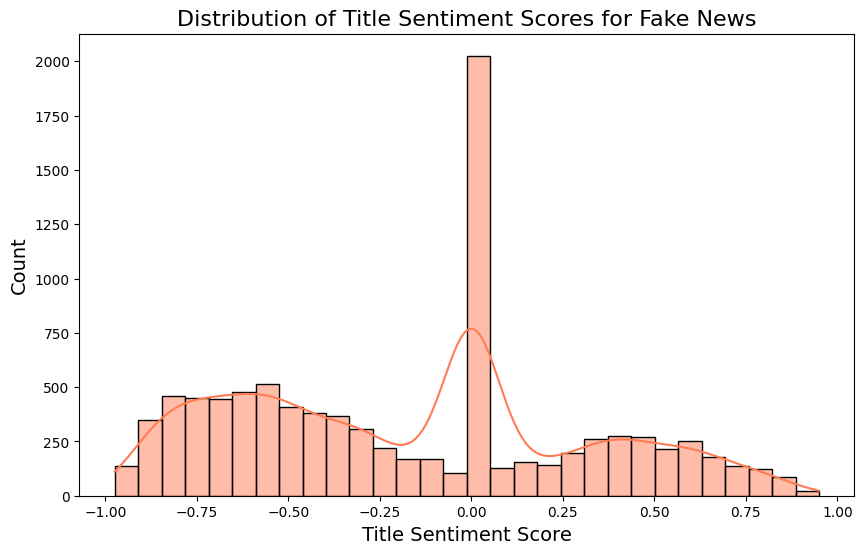

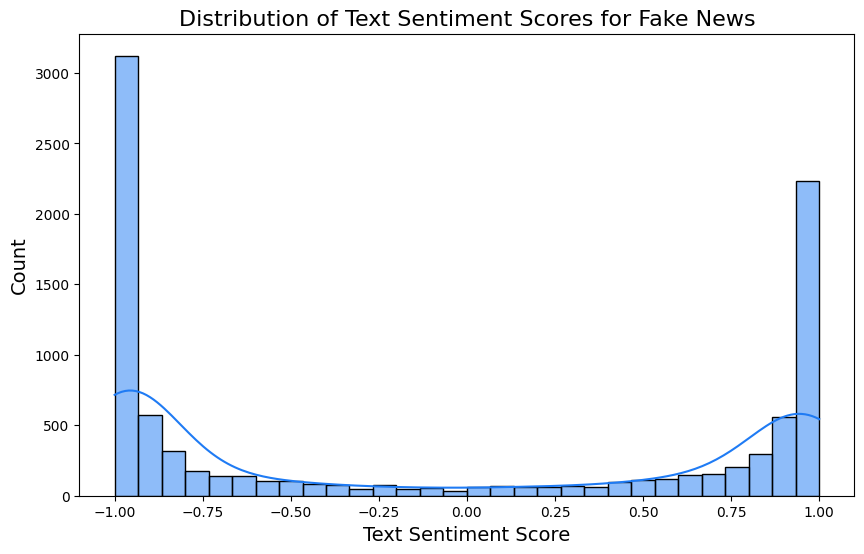

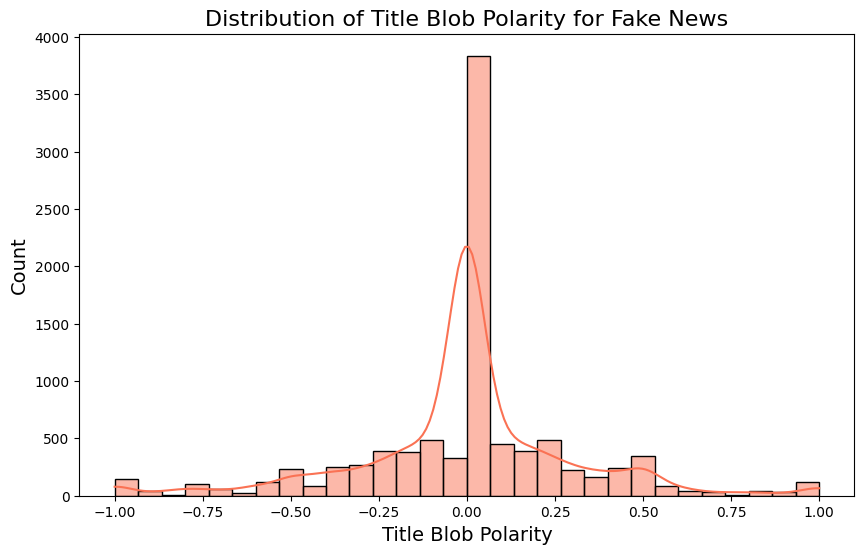

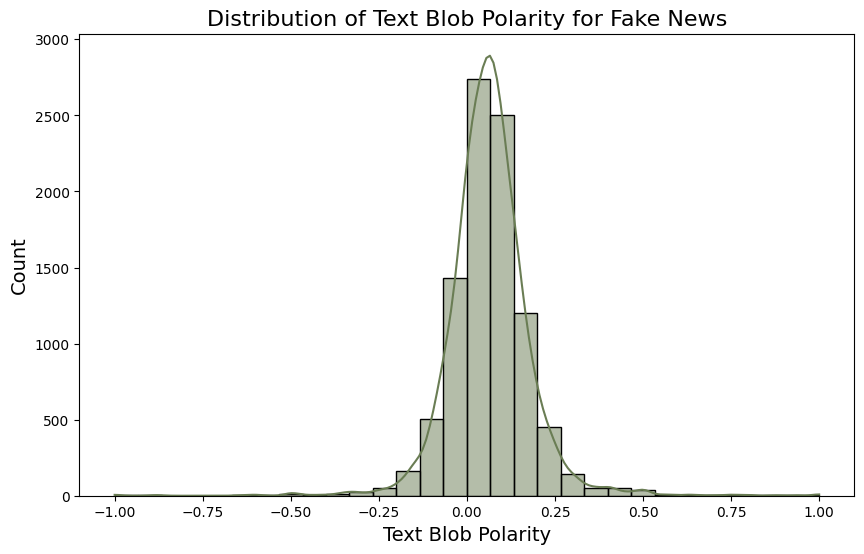

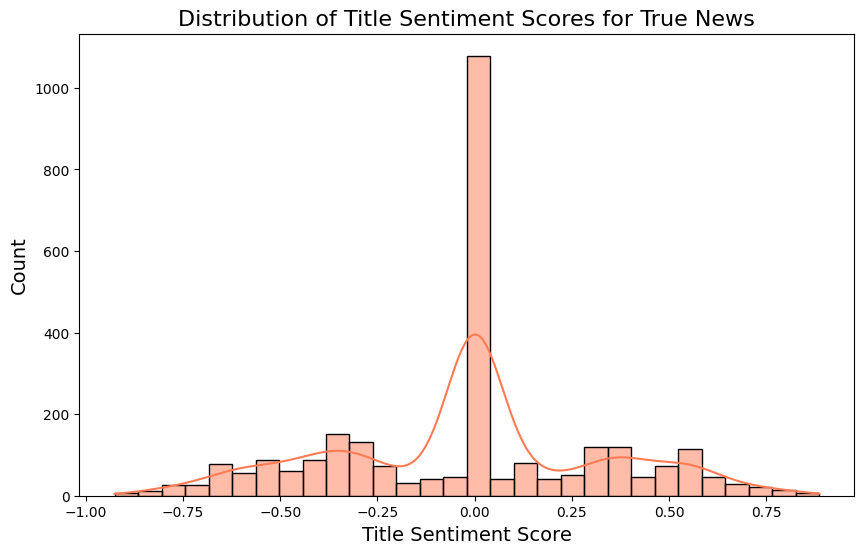

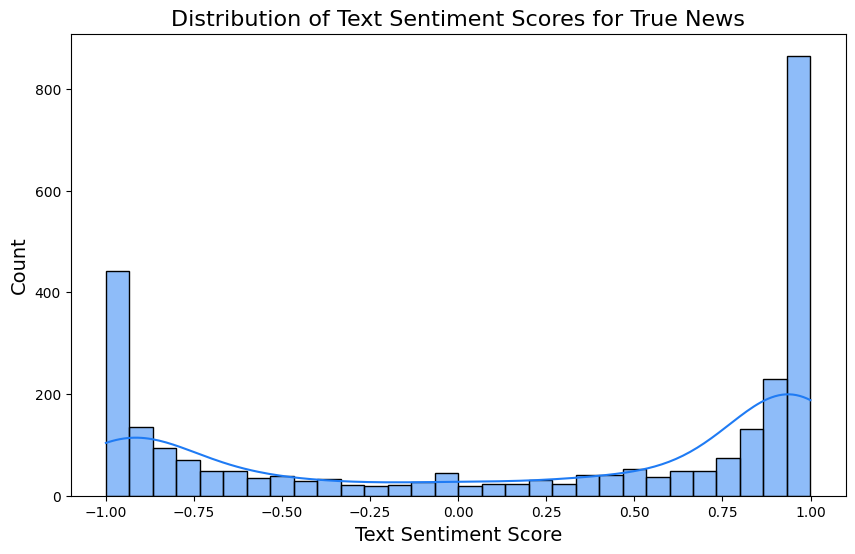

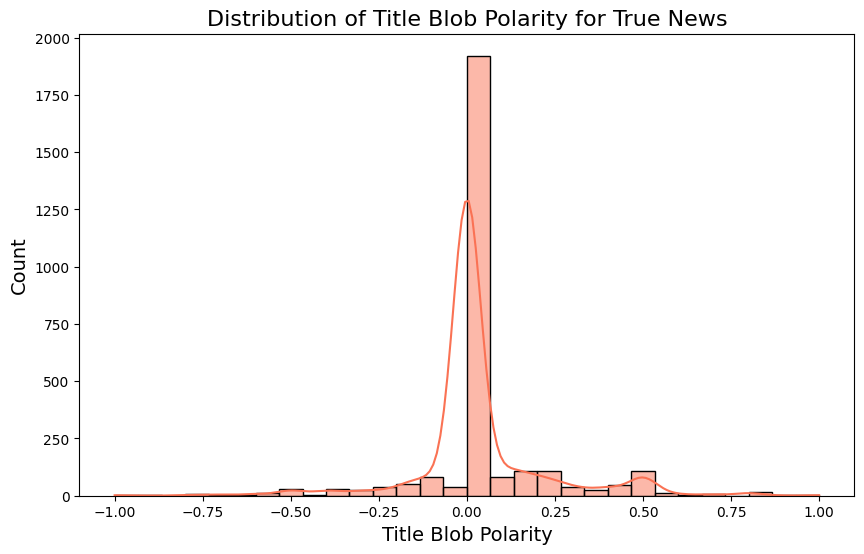

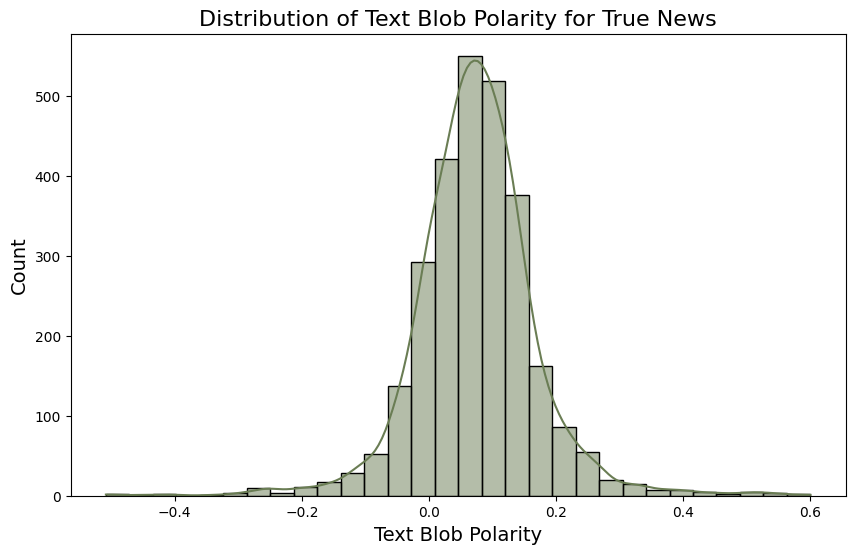

In [ ]:
# Filter the dataframe based on the 'fake' variable
fake_news = nnews[nnews['fake'] == 1]
true_news = nnews[nnews['fake'] == 0]

# Plotting distribution of sentiment scores for fake news
plt.figure(figsize=(10, 6))
sns.histplot(fake_news['title_sentiment_score'], bins=30, color='#FF7B54', kde=True)
plt.xlabel('Title Sentiment Score', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Title Sentiment Scores for Fake News', fontsize=16)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(fake_news['text_sentiment_score'], bins=30, color='#1F7BF4', kde=True)
plt.xlabel('Text Sentiment Score', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Text Sentiment Scores for Fake News', fontsize=16)
plt.show()

# Plotting distribution of blob polarities for fake news
plt.figure(figsize=(10, 6))
sns.histplot(fake_news['title_textblob_polarity'], bins=30, color='#FA7254', kde=True)
plt.xlabel('Title Blob Polarity', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Title Blob Polarity for Fake News', fontsize=16)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(fake_news['text_textblob_polarity'], bins=30, color='#6A7D54', kde=True)
plt.xlabel('Text Blob Polarity', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Text Blob Polarity for Fake News', fontsize=16)
plt.show()

# Plotting distribution of sentiment scores for true news
plt.figure(figsize=(10, 6))
sns.histplot(true_news['title_sentiment_score'], bins=30, color='#FF7B54', kde=True)
plt.xlabel('Title Sentiment Score', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Title Sentiment Scores for True News', fontsize=16)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(true_news['text_sentiment_score'], bins=30, color='#1F7BF4', kde=True)
plt.xlabel('Text Sentiment Score', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Text Sentiment Scores for True News', fontsize=16)
plt.show()

# Plotting distribution of blob polarities for true news
plt.figure(figsize=(10, 6))
sns.histplot(true_news['title_textblob_polarity'], bins=30, color='#FA7254', kde=True)
plt.xlabel('Title Blob Polarity', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Title Blob Polarity for True News', fontsize=16)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(true_news['text_textblob_polarity'], bins=30, color='#6A7D54', kde=True)
plt.xlabel('Text Blob Polarity', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Text Blob Polarity for True News', fontsize=16)
plt.show()

In [ ]:
def Sentimnt(x):
    if x >= 0.05:
        return "Positive"
    elif x <= -0.05:
        return "Negative"
    else:
        return "Neutral"
#df['Sentiment'] = df['compound'].apply(lambda c: 'positive' if c >=0.00  else 'negative')
news['Sentiment_title'] = news['title_sentiment_score'].apply(Sentimnt)
news['Sentiment_text'] = news['text_sentiment_score'].apply(Sentimnt)

news.head()

title  \
37  STAND UP AND CHEER! UKIP Party Leader SLAMS Ge...   
38  Trump signals willingness to raise U.S. minimu...   
40  Trump Issues Warning To “200,000 man army” Tha...   
41  JUDGE DECLARES BABY NAME “Illegal” To Prevent ...   
44  OUCH! BUSH “BESTIE” Goes Against GOP Elites…EN...   

                                                 text       subject  \
37  He s been Europe s version of the outspoken Te...     left-news   
38   (This version of the story corrects the figur...  politicsNews   
40  Before you blame Trump for not being compassio...      politics   
41  Does a judge have the right to determine what ...     left-news   
44  That s gonna leave a mark Former Vice Presiden...      politics   

         date  fake  word_count  char_count  \
37 2016-03-08     1         303        1606   
38 2016-05-04     0         125         690   
40 2015-10-01     1         305        1659   
41 2016-05-04     1         281        1570   
44 2016-05-07     1         465        2652   

                                            cleantext  \
37  he been europe version outspoken ted cruz for ...   
38  this version story corrects figure for current...   
40  before you blame trump for not being compassio...   
41  does judge have right determine what mother or...   
44  gonna leave mark former vice president dick ch...   

                                       tokenized_text  cluster_label  \
37  [he, been, europe, version, of, the, outspoken...              1   
38  [this, version, of, the, story, corrects, the,...              2   
40  [before, you, blame, trump, for, not, being, c...              1   
41  [does, judge, have, the, right, to, determine,...              1   
44  [that, gon, na, leave, mark, former, vice, pre...              2   

    title_sentiment_score  text_sentiment_score  title_textblob_polarity  \
37                 0.7920               -0.9732                     0.00   
38                 0.2732               -0.6520                     0.00   
40                -0.3400               -0.9813                     0.00   
41                 0.0258               -0.9737                    -0.25   
44                 0.0000                0.9930                     0.00   

    text_textblob_polarity Sentiment_title Sentiment_text  
37                0.049167        Positive       Negative  
38                0.052386        Positive       Negative  
40                0.118194        Negative       Negative  
41                0.057543         Neutral       Negative  
44                0.083095         Neutral       Positive

In [ ]:
senti = news.groupby('Sentiment_text').count()['text'].reset_index().sort_values(by='text',ascending=False)
sns.set_style("white")
sns.set_palette("Set2")
senti.style.background_gradient()

In [ ]:
senti = news.groupby('Sentiment_title').count()['text'].reset_index().sort_values(by='text',ascending=False)
sns.set_style("white")
sns.set_palette("Set2")
senti.style.background_gradient()

In [ ]:
!pip install nrclex

INFO: pip is looking at multiple versions of nrclex to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nrclex: filename=NRCLex-3.0.0-py3-none-any.whl size=43310 sha256=08816118d13e723f5d6b4765a1c1c24f96020573c9bb22fdf379c1fcfdc3d3ad
  Stored in directory: /root/.cache/pip/wheels/d2/10/44/6abfb1234298806a145fd6bcaec8cbc712e88dd1cd6cb242fa
Successfully built nrclex


In [ ]:
from nrclex import NRCLex
import nltk
nltk.download('punkt')

# Function to get emotions from the text using NRC Emotion Lexicon
def get_emotions(text):
    emotion_scores = NRCLex(text).affect_frequencies
    return emotion_scores

# Apply NRC Emotion Lexicon to the 'cleantext' column
news['emotions'] = news['cleantext'].apply(get_emotions)

# Let's check the emotions for the first few rows
print(news['emotions'].head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


37    {'fear': 0.08974358974358974, 'anger': 0.07692...
38    {'fear': 0.09090909090909091, 'anger': 0.09090...
40    {'fear': 0.0967741935483871, 'anger': 0.096774...
41    {'fear': 0.13076923076923078, 'anger': 0.06153...
44    {'fear': 0.0967741935483871, 'anger': 0.072580...
Name: emotions, dtype: object


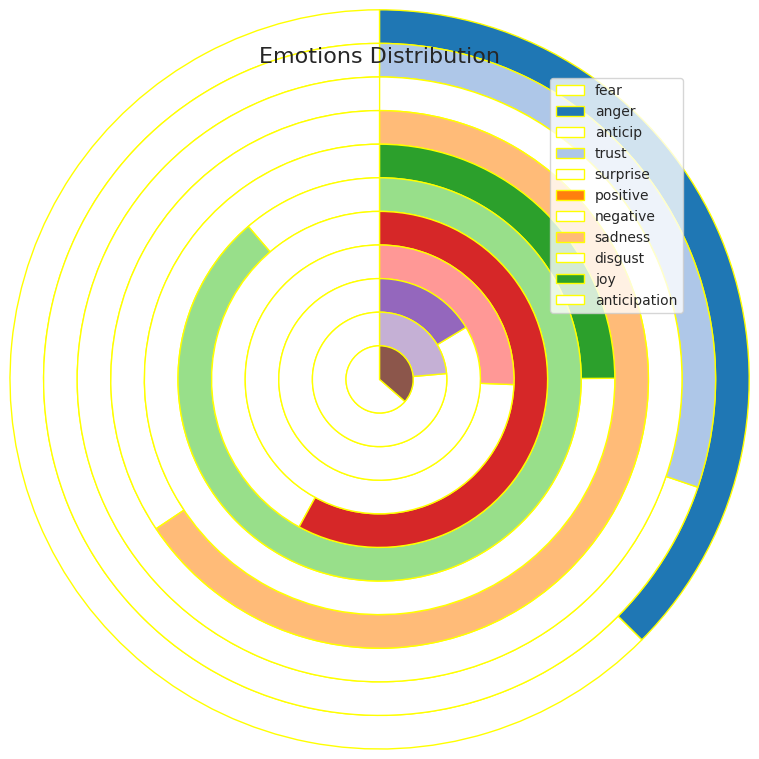

In [ ]:
from math import log10
from matplotlib import cm
import matplotlib.pyplot as plt


# Extracting emotions and converting to a DataFrame
emotions_df = pd.DataFrame(news['emotions'].tolist(), index=news.index)

# Summing up the emotions for each row
emotions_df['Total'] = emotions_df.sum(axis=1)

# Filter rows where emotions are present
df_chart = emotions_df[emotions_df['Total'] > 0]

# Extracting the emotions names as index and their corresponding counts
labels = df_chart.columns[:-1]
data = df_chart[labels].sum()

# Number of data points
n = len(data)

# Find max value for full ring
k = 10 ** int(log10(max(data)))
m = k * (1 + max(data) // k)

# Radius of donut chart
r = 1.5

# Calculate width of each ring
w = r / n

# Create custom colors for each emotion using tab20 colormap
cmap = plt.get_cmap('tab20')
colors = [cmap(i) for i in range(n)]

# Create figure, axis with a larger size
fig, ax = plt.subplots(figsize=(8, 8))
ax.axis("equal")

# Create rings of the donut chart
for i in range(n):
    # Hide labels in segments with textprops: alpha = 0 - transparent, alpha = 1 - visible
    innerring, _ = ax.pie([m - data[i], data[i]], radius=r - i * w, startangle=90, labels=["", labels[i]], labeldistance=1 - 1 / (1.5 * (n - i)), textprops={"alpha": 0}, colors=["white", colors[i]])
    plt.setp(innerring, width=w, edgecolor="yellow")

# Add the legend
ax.legend(labels, loc='best')

plt.title('Emotions Distribution', fontsize=16)
plt.show()